# Load occupancy data: RC-60-Mix

In [3]:
import numpy as np 
import pandas as pd

In [2]:
root_folder = 'preprocessed_data/'
f_x = root_folder + '058_5p_to_1p_X.txt'
f_y = root_folder + '058_5p_to_1p_y.txt'
data = pd.read_csv(f_x, delimiter=' ', header = None)
labels = pd.read_csv(f_y, delimiter=' ', header = None)
print(data.shape, labels.shape)

(4340, 5976) (4340, 1)


# RC-60-Mix: extract subdata by each label and produce 2d data

In [3]:
from utils.sampling import extract_car_data, generate_2d_data, get_all_cars_2d

In [4]:
bin_length, stride = 6, 1
total_bin = None

In [5]:
unique_labels = [1, 2, 3, 4, 5]
aggregate_data, aggregate_label = get_all_cars_2d(data, labels, unique_labels, bin_length, stride, total_bin)

# Transfer exact occupancy labels to HOV/LOV
* (1) LOV: 1 or 2 people => label = 2 
* (2) HOV: 3, 4, or 5 people => label = 1


In [10]:
def transfer_to_HOV_LOV(labels):# HOV: label=1 ; LOV: label=2
    if len(labels.shape)==2:
        labels = np.squeeze(labels).tolist()
    for idx, l in enumerate(labels):
        if l == 1:#5people: HOV
            labels[idx]=1
        elif l==2:#4people: HOV
            labels[idx]=1
        elif l==3:#3people
            labels[idx]=1
        elif l==4:#2people
            labels[idx]=2
        elif l==5:
            labels[idx]=2
        else:
            raise SystemExit("invalid label")
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=1)
    return labels

In [11]:
new_aggregate_label = transfer_to_HOV_LOV(aggregate_label.copy())

# Train 2d cnn on RC-60-Mix

In [15]:
from das_lib.models import cnn2d_dropout
from das_lib.funs import split_train_test_2d

2023-07-10 13:07:27.112481: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [16]:
from das_lib.funs import *
test_frac = .2
aggregate_data= np.expand_dims(aggregate_data,-1)
y_one_hot = tf.keras.utils.to_categorical(new_aggregate_label-1, num_classes=2)
x_train, x_test, y_train, y_test, training_index = split_train_test_2d(aggregate_data, y_one_hot, test_frac)
m = cnn2d_dropout( (x_train.shape[1], x_train.shape[2],1), y_train.shape[1])
print(m.summary())

2023-07-10 13:08:01.381097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 13:08:01.973294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0


Model: "1dcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 5976, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 4, 5913, 16)       3088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 739, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 739, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 724, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 90, 32)        0         
 2D)                                                   

In [17]:
x_train.shape, y_train.shape

((3447, 6, 5976, 1), (3447, 2))

In [18]:
H = m.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_test, y_test), verbose=False)
m.evaluate(x_test, y_test, batch_size=64, verbose=True)

2023-07-10 13:08:14.910743: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-07-10 13:08:20.740741: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 0.9838


[0.007352137938141823, 0.9837775230407715]

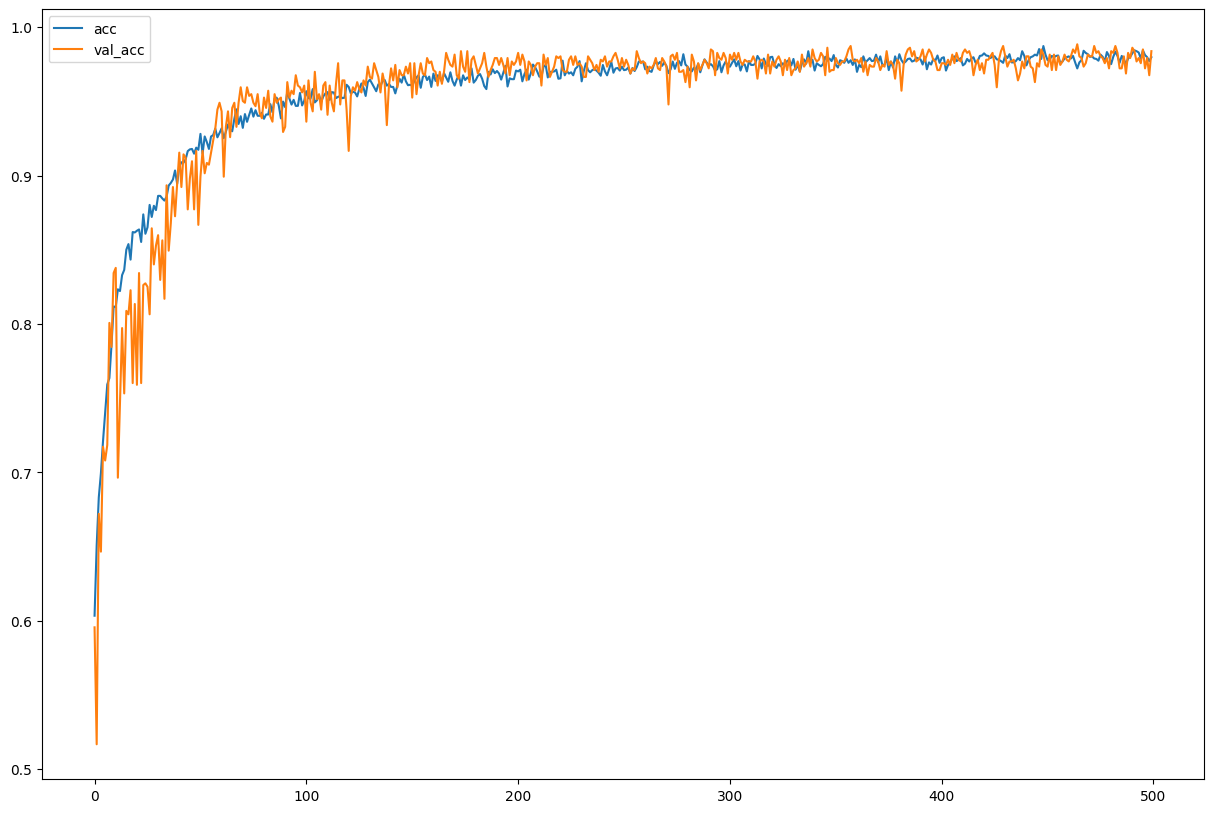

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.plot(H.history['accuracy'], label='acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.legend()

In [28]:
checkpoint_folder = 'training_results'
model_name = '2way_2d'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m.save(checkpoint_path)

INFO:tensorflow:Assets written to: training_results/2way_2d/assets


INFO:tensorflow:Assets written to: training_results/2way_2d/assets


In [ ]:
from das_lib.evaluation import save_training_history
f_name = 'performance/2way_2d.json'
save_training_history(f_name, H)

# Read the trained model

In [1]:
import tensorflow as tf
checkpoint_folder = 'training_results'
model_name = '2way_2d'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m = tf.keras.models.load_model(checkpoint_path)

2023-07-10 16:03:15.991139: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 16:03:44.893216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:03:47.629578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0


# Validate the trained model on Ind. RC-60-1p

In [6]:
from utils.sampling import extract_car_data, generate_2d_data
root_folder = 'preprocessed_data/'
f_x = root_folder+'026_X.txt' 
f_y = root_folder+'026_y.txt'
car_label = 2 # in speed data (023-027), car 2 is label = 2
car2_data =  extract_car_data(f_x, f_y, car_label)

In [8]:
bin_length, stride, total_bin = 6, 1, None
car2_1p_data, car2_1p_label_old = generate_2d_data(car2_data, car_label, bin_length, stride, total_bin)

In [9]:
def expand_data(data, label, num_classes):
    data= np.expand_dims(data,-1)
    label = np.array([label]*len(data))
    label = tf.keras.utils.to_categorical(label-1, num_classes)
    return data, label

In [10]:
label = 2 # in terms of occupancy, we have 1p driving car 2 => label = 2
num_classes = 2
car2_1p_data, car2_1p_label_new = expand_data(car2_1p_data, label, num_classes)

In [11]:
car2_1p_data.shape, car2_1p_label_new.shape

((445, 6, 5976, 1), (445, 2))

In [12]:
results = m.evaluate(car2_1p_data, car2_1p_label_new)

2023-07-10 16:06:37.569772: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-07-10 16:06:43.212661: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 9s 8ms/step - loss: 0.1789 - accuracy: 0.6225


In [13]:
from das_lib.evaluation import save_wrong_indices
f_name = 'performance/wrong_indices/2way_2d_1p.json'
save_wrong_indices(f_name, m, car2_1p_data, car2_1p_label_new)

14/14 [==============================] - 0s 5ms/step


# Validate the trained mode on Ind. RC-60-5p

In [14]:
root_folder = 'preprocessed_data/'
f_x = root_folder+'058_5p_X.txt' 
f_y = root_folder+'058_5p_y.txt'
car_label = 1 #old label, direction west => label=1
car2_5p_data = extract_car_data(f_x, f_y, car_label)
car2_5p_data, car2_5p_label_old = generate_2d_data(car2_5p_data, car_label, bin_length, stride, total_bin)

In [15]:
label = 1 #new label, 5p in car 2 = > label = 1 
num_classes = 2
car2_5p_data, car2_5p_label_new = expand_data(car2_5p_data, label, num_classes)

In [16]:
car2_5p_data.shape, car2_5p_label_new.shape

((285, 6, 5976, 1), (285, 2))

In [17]:
results = m.evaluate(car2_5p_data, car2_5p_label_new)

9/9 [==============================] - 0s 5ms/step - loss: 0.2483 - accuracy: 0.5228


In [18]:
f_name = 'performance/wrong_indices/2way_2d_5p.json'
save_wrong_indices(f_name, m, car2_5p_data, car2_5p_label_new)

9/9 [==============================] - 0s 5ms/step
